In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'database': 'SQLTEST',
    'user': 'postgres',
    'password': 'Admin'
}

In [3]:

def get_db_connection():
    try:
        conn = psycopg2.connect(
            host=DB_CONFIG['host'],
            database=DB_CONFIG['database'],
            user=DB_CONFIG['user'],
            password=DB_CONFIG['password']
        )
        return conn
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None

In [4]:
def fetch_data(query):
    conn = get_db_connection()
    if conn:
        try:
            df = pd.read_sql_query(query, conn)
            conn.close()
            return df
        except Exception as e:
            print(f"Error executing query: {e}")
            conn.close()
            return None

In [5]:
queries = {
    'conversion_rate': """
        SELECT 
            (COUNT(DISTINCT g.id) * 100.0 / NULLIF(COUNT(DISTINCT gd.id), 0)) AS conversion_rate
        FROM 
            public.group_deals gd
        LEFT JOIN 
            public.groups g ON g.group_deals_id = gd.id
        WHERE 
            g.status = 'COMPLETED';
    """,
    'conversion_rate_over_time': """
        SELECT 
            DATE(gd.created_at) AS deal_date,
            (COUNT(DISTINCT g.id) * 100.0 / NULLIF(COUNT(DISTINCT gd.id), 0)) AS conversion_rate
        FROM 
            public.group_deals gd
        LEFT JOIN 
            public.groups g ON g.group_deals_id = gd.id
        WHERE 
            g.status = 'COMPLETED'
        GROUP BY DATE(gd.created_at)
        ORDER BY DATE(gd.created_at);
    """,
    'deal_status_proportion': """
        SELECT 
            g.status, 
            COUNT(g.id) AS deal_count
        FROM 
            public.group_deals gd
        LEFT JOIN 
            public.groups g ON g.group_deals_id = gd.id
        GROUP BY g.status;
    """
}

In [6]:
conversion_rate = fetch_data(queries['conversion_rate'])
conversion_rate_over_time = fetch_data(queries['conversion_rate_over_time'])
deal_status_proportion = fetch_data(queries['deal_status_proportion'])

C:\Users\huawei\AppData\Local\Temp\ipykernel_5284\1133463567.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [7]:
sns.set(style="whitegrid")


#  Trend Line: Conversion Rate Over Time

c:\Users\huawei\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\huawei\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


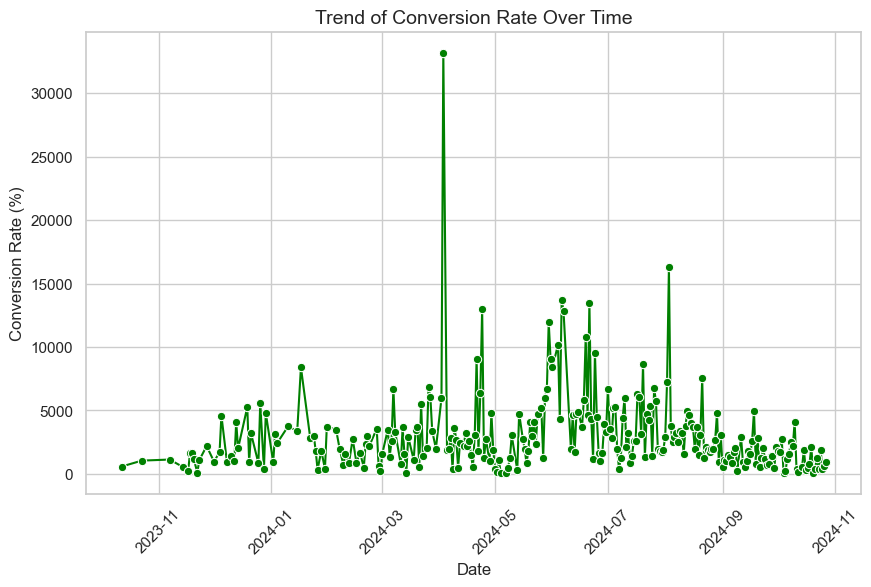

In [8]:

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=conversion_rate_over_time['deal_date'], 
    y=conversion_rate_over_time['conversion_rate'], 
    marker='o', color='green'
)
plt.title('Trend of Conversion Rate Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.show()

In [9]:
deal_status_proportion = pd.DataFrame({
    'status': ['COMPLETED', 'ACTIVE', 'FAILED', 'PENDING'],
    'deal_count': [750, 100, 5, 1200]
})

threshold = 10  # U can Change The threshold Value To what u wish 
deal_status_proportion['status'] = deal_status_proportion.apply(
    lambda row: 'Others' if row['deal_count'] < threshold else row['status'], axis=1
)


deal_status_proportion = deal_status_proportion.groupby('status', as_index=False).sum()

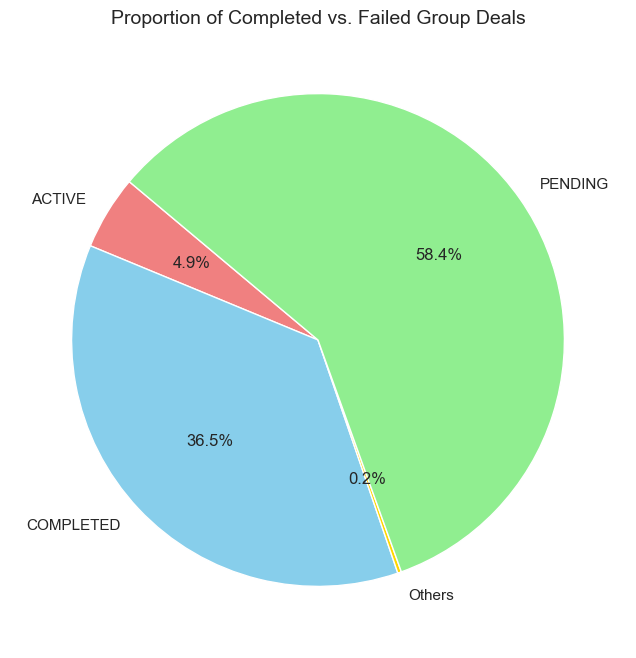

In [10]:
plt.figure(figsize=(8, 8))
plt.pie(
    deal_status_proportion['deal_count'], 
    labels=deal_status_proportion['status'], 
    autopct='%1.1f%%',
    colors=['lightcoral', 'skyblue', 'gold', 'lightgreen', 'lightgrey'],
    startangle=140
)
plt.title('Proportion of Completed vs. Failed Group Deals', fontsize=14)
plt.show()